In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import Samplers

There is a target dist called p(x), but we only know f(x). p(x) = f(x)/NormalizingConstant(NC)
NC usually makes sure, that AUC of target dist density is 1

In [2]:
def f(x):
    if x >= 1:
        return np.exp(-(x-1)/2) + np.exp(-(x-1)**2)
    else:
        return np.exp((x-1)/3) + np.exp((x-1)**3)

### Target Distribution

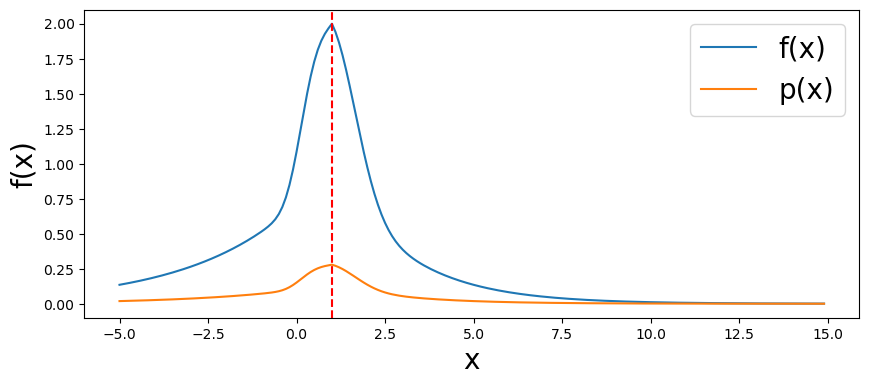

In [3]:
NC = 7.16556
x_vals = np.arange(-5,15,.1)
f_vals = [f(x) for x in x_vals]
p_vals = [f/NC for f in f_vals]

TRUE_EXP = 1.94709 / NC

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, p_vals)
plt.legend(["f(x)", "p(x)"], fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.ylabel("f(x)", fontsize = 20)
plt.axvline(1, color = "r", linestyle = "--")

### Accept-Reject-Sampling with N ~ (0,3)

Since NC is unknown, we use a Sampling method to sample from p(x) via the non-normalized target dist f(x) and a proposal dist g(x). 
g(x) needs to ideally fulfill three (but at least the first two) requirements: 
   1. be easy to sample from 
   2. span same sample space as f(x) 
   3. density curve should have similiar form (but often only a uniform distribution is used).
      
via these samples we can estimate the parameters of p(x)

In [4]:
# as a proposal distribution function g(x) we use a normal PDF
def g(x, mu, sigm):
    return scipy.stats.norm(mu, sigm).pdf(x)
    

In [5]:
x_vals = np.arange(-30,30,.1)
f_vals = [f(x) for x in x_vals]
g_vals = g(x_vals, 0, 3)

g(x) needs to be scaled by a scaling Factor M, that makes sure that the density curve of g(x) is always (mostly) above the curve of f(x). This is because the acceptance or rejection of a sample is based on the ratio of f(x)/g(x) for a given x which is interpreted as a probability und therefore needs to be an element of {0,1}. Hence g(x) > f(x).

Text(0.5, 1.0, 'M=1000')

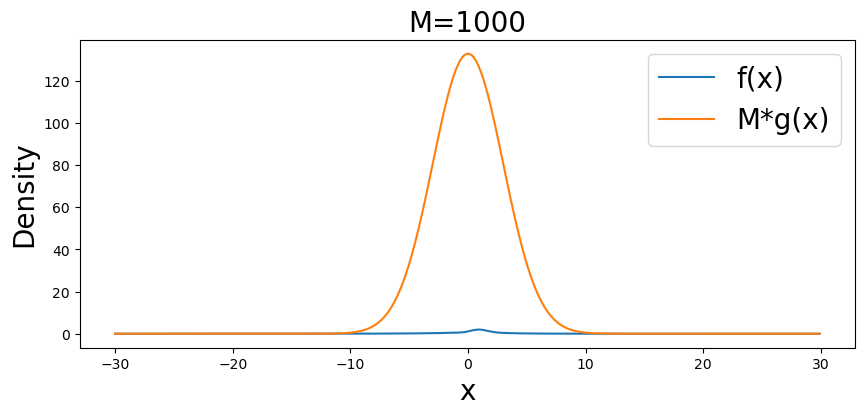

In [6]:
M = 1000

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel("x", fontsize = 20)
plt.ylabel("Density", fontsize = 20)
plt.legend(["f(x)", "M*g(x)"], fontsize = 20)
plt.title("M=%s"%M, fontsize = 20)

In [84]:
number_trials = 1000000
samples = Samplers.accept_reject_sampling(candidate_mu= 0, candidate_sigma= 3, scale_factor= M, target_distribution= f,proposal_distribution= g, trials= number_trials)

In [85]:
print("%s Samples were accepted." %len(samples))

6728 Samples were accepted.


In [86]:
print("The acceptance rate of sampling (Efficiency) was %s." %round(len(samples)/number_trials,3))

The acceptance rate of sampling (Efficiency) was 0.007.


Text(0.5, 1.0, 'Empirical Exp. Value: 0.29\n True Exp. Value: 0.27')

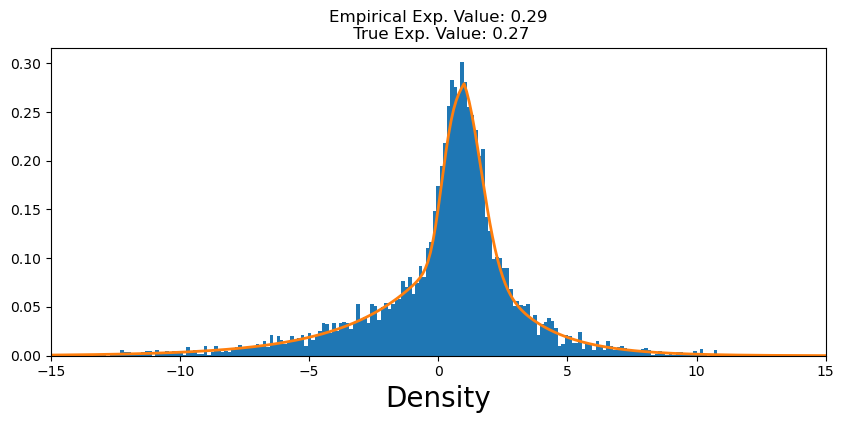

In [87]:
plt.figure(figsize = (10,4))
plt.hist(samples, bins = 200, density= True)
plt.xlabel("x", fontsize = 20)
plt.xlabel("Density", fontsize = 20)
plt.plot(x_vals, [f/NC for f in f_vals], linewidth = 2)
plt.xlim(-15,15)

plt.title(f"Empirical Exp. Value: %s\n True Exp. Value: {round(TRUE_EXP,2)}" %round(np.mean(samples),2))

The third (optional) prerequisite for our proposal distribution comes into play when we look at computational efficiency.
The worse the fit of our proposal distribution g(x) over f(x), the worse the centering and the higher M needs to be to account for extreme values of f(x) (not a problem if we use a uniform dist as g(x). Since M influences our acceptance rate negatively (rate = f(x)/M*g(x)), we generate less samples and need a higher count of trials and therefore a higher computational effort.  

### General Problem of AR-Sampling

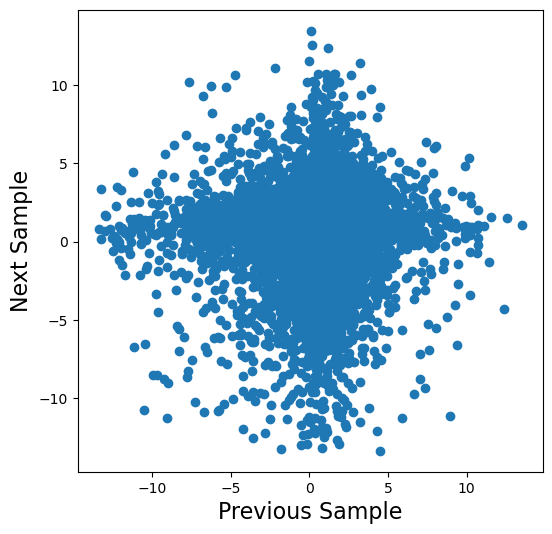

In [88]:
plt.figure(figsize = (6,6))
plt.scatter(samples[:-1],samples[1:])
plt.xlabel("Previous Sample", fontsize = 16)
plt.ylabel("Next Sample", fontsize = 16)
plt.show()

Problem: consecutive samples are fully uncorrelated -> we don´t learn from our mistakes!
This is where MCMC-methods such as the Metropolis-Algorithm come in.

### The Metropolis Sampler

The Metropolis Sampler generally functions pretty similiar to the AR-Sampler. But instead of drawing a completely new sample from a proposal dist, it centers the proposal dist in the next iteration on the random sample from the last iteration. It again calculates the probability of acceptance as the ratio, but this time between this iteration and the last and if the probability is higher than chance appends the new random sample, if not the random sample from the last iteration. Hence the "Markov Chain" part in MCMC. 
There is a "burn-in"-period until our markov chain reaches its stationary. The values sampled during these iterations are disregarded. A common range used for this is 1000 iterations.

In [7]:
number_trials = 1000000
samples = Samplers.metropolis_sampling(candidate_sigma= 4, target_distribution= f, trials= number_trials, burn_in= 1000)

Text(0.5, 1.0, 'Empirical Exp. Value: 0.27\n True Exp. Value: 0.27')

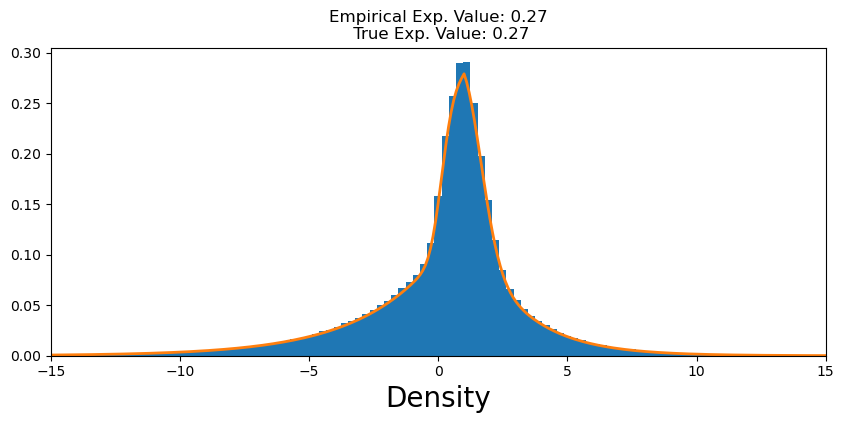

In [11]:
plt.figure(figsize = (10,4))
plt.hist(samples, bins = 200, density= True)
plt.xlabel("x", fontsize = 20)
plt.xlabel("Density", fontsize = 20)
plt.plot(x_vals, [f/NC for f in f_vals], linewidth = 2)
plt.xlim(-15,15)

plt.title(f"Empirical Exp. Value: %s\n True Exp. Value: {round(TRUE_EXP,2)}" %round(np.mean(samples),2))

In [8]:
print("%s Samples were accepted." %len(samples))

999000 Samples were accepted.


In [9]:
print("The acceptance rate of sampling (Efficiency) was %s." %round(len(samples)/number_trials,3))

The acceptance rate of sampling (Efficiency) was 0.999.


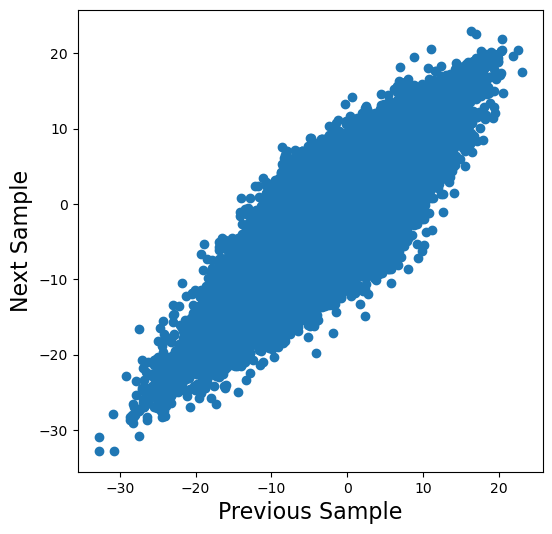

In [10]:
plt.figure(figsize = (6,6))
plt.scatter(samples[:-1],samples[1:])
plt.xlabel("Previous Sample", fontsize = 16)
plt.ylabel("Next Sample", fontsize = 16)
plt.show()

The steps is highly correlated.